In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import text, sequence
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    accuracy_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import (
    Dense, 
    Embedding, 
    LSTM, 
    Dropout, 
    GRU, 
    Bidirectional
)
from keras.callbacks import ReduceLROnPlateau
# import tensorflow as tf
import os
import urllib.request
import zipfile
from tqdm import tqdm
import requests


2023-12-05 18:20:37.518662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mikhailwladimirovichkuznetsov/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Download Data from kaggle

Source : <a hreaf="https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification">kaggle</a>. Download it <a href="https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification/download?datasetVersionNumber=77">HERE</a>.


### Load Data

Data Info :

(WELFake) is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training.

Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).

There are 78098 data entries in csv file out of which only 72134 entries are accessed as per the data frame.

NOTE : Based on <a href="https://www.kaggle.com/code/madz2000/nlp-using-glove-embeddings-99-87-accuracy/notebook">this kaggle notebook</a>.

In [2]:
df = pd.read_csv("WELFake_Dataset.csv")
mapper = {
    0 : "fake",
    1 : "real",
}

In [3]:
# print(df.columns) # Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')
if "Unnamed: 0" in df.columns:
    df.drop("Unnamed: 0", axis=1, inplace=True)

In [4]:
df.fillna("")
headline = df["title"]
news = df["text"]
df["tot_news"] = df["title"].astype("str") + " " + df["text"].astype("str")
tot_news = df["tot_news"]
labels = df["label"]

In [5]:
fake_news = news[labels == 0]
real_news = news[labels == 1]
# print(fake_news)

### Download glove model

In [6]:
glove_url = "https://nlp.stanford.edu/data/glove.840B.300d.zip"


_, tail = os.path.split(glove_url)
# print(tail)
already_extracted = any(i.startswith(os.path.splitext(tail)[0]) for i in os.listdir())
already_downloaded = os.path.isfile(tail)
if not (already_extracted or already_downloaded):
    resp = requests.get(glove_url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(tail, 'wb') as file, tqdm(
        desc=tail,
        total=total,
        unit='iB',
        unit_scale=True,
        unit_divisor=2048,
    ) as bar:
        for data in resp.iter_content(chunk_size=2048):
            size = file.write(data)
            bar.update(size)
# if not os.path.isfile(tail):
#     urllib.request.urlretrieve(glove_url, tail)
dest_folder = os.getcwd()

try:
    zip_file = zipfile.ZipFile(tail)
    zip_file.extractall(dest_folder)
except Exception as e:
    if e.__class__.__name__ == "BadZipFile":
        print(f"Your downloaded file is corrupt! RETRY !")
finally:
    if os.path.isfile(tail):
        os.remove(tail)

In [7]:
EMBEDDING_FILE = os.path.splitext(tail)[0] + ".txt"
# def get_coefs(word, *arr): 
#     return word, np.asarray(arr, dtype='float32')
embeddings_index = {}
with open(EMBEDDING_FILE, "r") as f:
    for line in tqdm(f):
        values = line.split(" ")
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

2196017it [02:23, 15300.45it/s]

Found 2196016 word vectors.


### Training

In [8]:
# X = tot_news.values
X = tot_news

Y = labels.values
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=73939133)

In [9]:
max_features = 10000
maxlen = 300
batch_size = 256
epochs = 10
embed_size = 100
# embed_size = 300

In [10]:
tokenizer = text.Tokenizer(num_words=max_features,  lower=None)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)


In [11]:
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    verbose=True,
    factor=0.6, 
    min_lr=0.00001
)

In [23]:
model4 = Sequential()
#Non-trainable embeddidng layer
model4.add(Embedding(
    max_features, 
    output_dim=embed_size, 
    weights=[embedding_matrix], 
    input_length=maxlen, 
    trainable=False))
#LSTM 
model4.add(Bidirectional(
    LSTM(
        # units=128, 
        units=64, 
        return_sequences=True, 
        recurrent_dropout=0.25, 
        dropout=0.25)
    ))
model4.add(Bidirectional(GRU(
    # units=64, 
    units=32, 
    return_sequences=True, 
    recurrent_dropout=0.1, 
    dropout=0.1)))
model4.add(Bidirectional(LSTM(
    units=32, 
    # units=32, 
    # return_sequences=True, 
    recurrent_dropout=0.1, 
    dropout=0.1)))

model4.add(Dense(units=32, activation="relu"))
model4.add(Dense(1, activation="sigmoid"))
model4.compile(
    optimizer=keras.optimizers.Adam(lr=0.01), 
    loss="binary_crossentropy", 
    metrics=["accuracy"])
model4.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          3000000   
                                                                 
 bidirectional_6 (Bidirecti  (None, 300, 128)          186880    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 300, 64)           31104     
 onal)                                                           
                                                                 
 bidirectional_8 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                      

In [19]:
history = model4.fit(
    x_train, 
    y_train, 
    batch_size=batch_size, 
    validation_data=(x_test,y_test), 
    epochs=epochs, 
    callbacks=[learning_rate_reduction])

Epoch 1/10
212/212 [==============================] - 885s 4s/step - loss: 0.2828 - accuracy: 0.8805 - val_loss: 0.1775 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 2/10
212/212 [==============================] - 824s 4s/step - loss: 0.2224 - accuracy: 0.9104 - val_loss: 0.2000 - val_accuracy: 0.9292 - lr: 0.0010
Epoch 3/10
212/212 [==============================] - 837s 4s/step - loss: 0.1734 - accuracy: 0.9358 - val_loss: 0.1549 - val_accuracy: 0.9419 - lr: 0.0010
Epoch 4/10
212/212 [==============================] - 842s 4s/step - loss: 0.1351 - accuracy: 0.9499 - val_loss: 0.1246 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 5/10
212/212 [==============================] - 890s 4s/step - loss: 0.1128 - accuracy: 0.9584 - val_loss: 0.1073 - val_accuracy: 0.9589 - lr: 0.0010
Epoch 6/10
212/212 [==============================] - 728s 3s/step - loss: 0.0980 - accuracy: 0.9631 - val_loss: 0.0971 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 7/10
212/212 [==============================] - 658s 3s/st

### Inference

In [20]:
print("Accuracy of the model on Training Data is - " , model4.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model4.evaluate(x_test,y_test)[1]*100 , "%")

1691/1691 [==============================] - 338s 200ms/step - loss: 0.0431 - accuracy: 0.9846
Accuracy of the model on Training Data is -  98.4639585018158 %
564/564 [==============================] - 113s 199ms/step - loss: 0.0754 - accuracy: 0.9714
Accuracy of the model on Testing Data is -  97.13873863220215 %


In [21]:
model4.save('./test4.keras')

564/564 [==============================] - 126s 221ms/step
Model 4 accuracy : 0.9714
Model 4 confusion matrix :


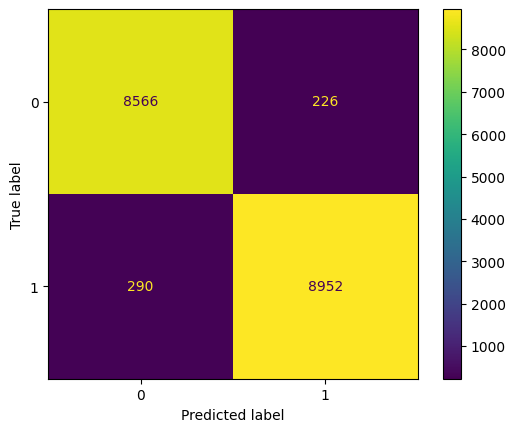

Model 4 report : 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      8792
           1       0.98      0.97      0.97      9242

    accuracy                           0.97     18034
   macro avg       0.97      0.97      0.97     18034
weighted avg       0.97      0.97      0.97     18034



In [22]:
y_pred = model4.predict(x_test)
y_pred = np.rint(y_pred)
acc = accuracy_score(y_test, y_pred)
print(f"Model 4 accuracy : {acc:.4f}")
confmat = confusion_matrix(y_test, y_pred)
print(f"Model 4 confusion matrix :")
# y_test # array([1, 0, 1, ..., 1, 1, 1])
disp = ConfusionMatrixDisplay(confmat)
disp.plot()
plt.savefig('confmat_model4.png', dpi=300)
plt.show()
clasfnrep = classification_report(y_test, y_pred)
print(f"Model 4 report : \n{clasfnrep}")